In [1]:
from qrisp import *
from qrisp.quantum_backtracking import OHQInt
from zander_preparation import *

import numpy as np
import networkx as nx

from qrisp import *


def create_cost_operator(C, G, root, N):
# quantum cost operator exp(-i*gamma*H)
# $H = sum_{(r,s)\in\Phi}\sum_{i,j=0}^{N-1}C_{ij}^r*(1-Z_{ri}-Z_{sj}-Z_{ri}Z_{sj})
    def cost_operator(q_array, gamma):
        global_phase = 0
        phases = [0]*N

        recursive_create_cost_operator(q_array, gamma, C, G, root, N, phases, global_phase)
        gphase(-gamma/4*global_phase,q_array[0][0])
    
    return cost_operator

# recursive method for creating the cost operator
def recursive_create_cost_operator(q_array, gamma, C, G, node, N, phases, global_phase):
    predecessors = list(G.predecessors(node))
    pred_phases = {} # phases to pass to the cost operator for each predecessor of the current node
    for pred in predecessors:
        pred_phases[pred]= [0]*N

    for i in range(N):
        phase = 0
        for pred in predecessors:
            phase += sum(C[pred][:,i]) # sum coefficients of Z_{sj} for all edges (r,s) in the graph (nodes r are predecessors of s)
            pred_phases[pred][i] = sum(C[pred][i]) # sum coefficients of Z_{ri}

        global_phase += phase

        # Z_{sj}
        rz(-gamma/2*(phase+phases[i]), q_array[node][i])

        for j in range(N):
            for pred in predecessors:
                if C[pred][(i,j)] != 0:
                    # Z_{ri}Z_{sj}
                    rzz(gamma/2*C[pred][(i,j)], q_array[pred][i], q_array[node][j])

    for pred in predecessors:
        recursive_create_cost_operator(q_array, gamma, C, G, pred, N, pred_phases[pred], global_phase)




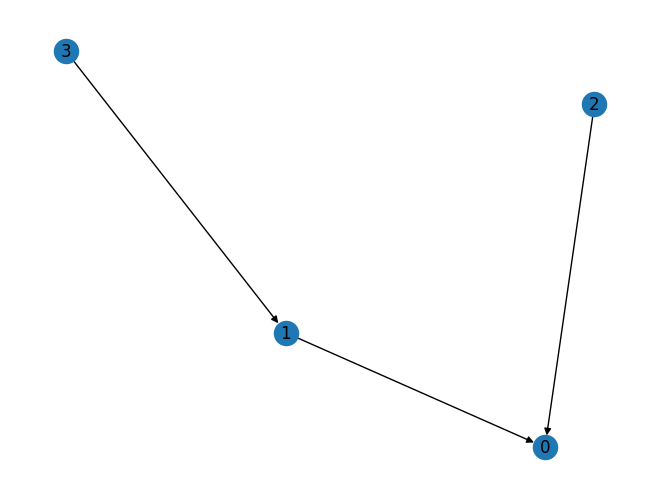

In [3]:
Phi = [(1,0),(2,0),(3,1)]

G = nx.DiGraph()
G.add_edges_from(Phi)
M = G.number_of_nodes() # Number of parts

nx.draw(G, with_labels=True)

N = 3
qtype = OHQInt(N)
q_array = QuantumArray(qtype = qtype, shape = (M))

#state = prepare_pbs_state(G, 0, N, q_array)

# Cost coefficients from Table.3
cost_coeff={
    1: {(0,1): 1.64,
        (0,2): 1.05,
        (1,2): 0.59,
        },
    
    2: {(0,1): 5.56,
        (0,2): 3.54,
        (1,2): 1.98,
        },
 
     3: {(0,1): 8.06,
         (0,2): 5.14,
         (1,2): 2.88
         },
    }
tot_coeff = {}

for k,v in cost_coeff.items():
  tot_coeff[k]= np.zeros((N, N))
  for rs,c in v.items():
    i,j=rs[0],rs[1]
    tot_coeff[k][i][j]=c
    tot_coeff[k][j][i]=c

tot_coeff

cost_op = create_cost_operator(tot_coeff,G,0,3)

In [4]:
cost_op(q_array, 0.2)

In [5]:
print(q_array.qs)

QuantumCircuit:
---------------
          ┌────────────┐                                                  »
  qv_1.0: ┤ Rz(-1.179) ├───────────────────────────■──────────────────────»
          └────────────┘            ┌────────────┐ │                      »
  qv_1.1: ──■────────────■──────────┤ Rz(-0.977) ├─┼──────────────────────»
            │            │          └────────────┘ │                      »
  qv_1.2: ──┼────────────┼────────────■────────────┼───────────■──────────»
            │ZZ(0.164)   │            │ZZ(0.105)   │           │          »
qv_1_1.0: ──■────────────┼────────────■────────────┼───────────┼──────────»
                         │                         │ZZ(0.164)  │          »
qv_1_1.1: ───────────────┼─────────────────────────■───────────┼──────────»
                         │                                     │          »
qv_1_1.2: ───────────────┼─────────────────────────────────────┼──────────»
                         │ZZ(0.556)                     